# Modelling Analysis
## Summary of the analysis
Despite of the fact that the class distribution is imbalanced, Naïve Bayes model worked quite well. This model is quite simple but its accuracy is quite well compared to Random undersampling + Bagging and FastText model and still it's very fast to train and the model size is also light. This model achieved accuracy score = 0.6869 on the test set.

### Naïve Bayes
From the heatmap of the confusion matrix, we can see that the model predictions are good overall. There are some misclassifications among "Artist", "Athlete" and "OfficeHolder" as expected. Also "Animal", "Village" and "Plant" seem to be difficult task to classify correctly. Yet, there's one concern about the "WrittenWork" class (=14). As this class was the minor class, it seems this class's classification wasn't quite well.

#### Use cleanNameExtra function for preprocessing (Remove "film" tag)
From the analysis I have found that there are "film" tags in both class "Film" and "WrittenWork" so I thought it might confuse the model. Here I remove the "file" tag to see if improves the accuracy.

As a result, the accuracy was worsen. I can imagine that there are many names that belong to either "Film" or "WrittenWork" but it's difficult to be classified without the tag. So that overall accuracy worse off.

### Random undersampling + Bagging
As a result, it improved quite a bit for the minor class (=14), however worse off in most other classes, especially the model is misclassifying "Company" names as "Vilage" and "Animal" names, which is quite interesting for me as Company names do sound different from both Village and Animal names and there was similar tendency in Naïve Bayes model as well.

It would still depend on how important to classify class = 14 correctly, but I feel Naïve Bayes model is still doing better in general.


#### Combining Naïve Bayes and random undersampling + bagging
From above, we can see that using random undersampling + bagging improves the classifying the minority class. So I thought if I combine those predictions to Naïve Bayes prediction, it might improve the accuracy.

It improved the overall accuracy slightly, but considering increasing the computational cost, probably it's better to use Naïve Bayes model by itself.

### FastText
Its accuracy is 0.7070 on the test set, which means successfully improved the score of Naïve Bayes. Yet since I couldn't figure out how to do the evaluation propoerly with this library, I will not use this model. But it is good to know that n-gram feture might be one of the reason why the model performance improved a bit so that I can try it with Naïve Bayes model. 

I did a little experiment with this model. I ran this model against some names and saw what will be the predicted class. When I tried with "streetbees ltd", it returned "Company" with likelihood of 0.9999. I think it is coming from "ltd". Also I tried with my name "kyosuke morita" (of course there's no my name in the dataset). The model predicted my name as "OfficeHolder", but when I add some "tag"s such as "boxer" and "bloger", the prediction changed to "Athlete" and "Artist", respectively. This means that the model learned a lot from the tags to classify the "human classes" and if we can have more of those, the accuracy will improve a lot.

## Table of contents
- [Naïve Bayes model](#Naïve-Bayes-model)
- [Random undersampling + Bagging model](#Random-undersampling-+-Bagging-model)
- [FastText model](#FastText-model)
- [Flair model](#Flair-model)

In [56]:
# Import modules
import csv
import re
import os
import io
from typing import List
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fasttext
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from flair.datasets import ClassificationCorpus, CSVClassificationCorpus
from flair.data import Corpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentLSTMEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path

In [2]:
os.chdir("/Users/kyosuke/projects/Streetbees")

In [3]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
def cleanNames(text, word_length=1):
    """Clean the text feature to be consumable for the model training
    Process:
    1. Remove all numbers
    2. Remove punctuation: `?` `!` `'` `"` `#` `:`
    3. Replace separators with spaces: `.` `,` `)` `(` `\` `/` `-`
    4. Remove all words shorter than a configurable length
    5. Replace sequences of more than one space with one space.
    6. lower the cases

    Args:
        text (str): the text feature
        word_length (int): the minimal length of a word

    Return:
        cleaned_text (str): cleaned text
    """

    # 1. Remove all numbers
    remove_numbers = str.maketrans(dict.fromkeys("0123456789"))
    modified_text = text.translate(remove_numbers)

    # 2. Remove punctuation: `?` `!` `'` `"` `#` `:` `~` `]` `[`
    punctuation = set("!\"#':?~][")
    modified_text = "".join([i for i in modified_text if i not in punctuation])

    # 3. Replace separators with spaces: `.` `,` `)` `(` `\` `/` `-`
    remove_punctuation = str.maketrans(dict.fromkeys(".,)(\/-"))
    modified_text = modified_text.translate(remove_punctuation)
    
    # 4. Remove all words shorter than a configurable length
    # -> will set the default word length as 1
    modified_text = " ".join(
        [w for w in modified_text.split() if len(w) > word_length]
    )

    # 5. Replace sequences of more than one space with one space.
    modified_text = " ".join(modified_text.split())
    
    # 6. lower the cases
    cleaned_text = modified_text.lower()

    return cleaned_text

In [126]:
def cleanNamesExtra(text, word_length=1):
    """Clean the text feature to be consumable for the model training
    Process:
    1. Remove all numbers
    2. Remove punctuation: `?` `!` `'` `"` `#` `:`
    3. Replace separators with spaces: `.` `,` `)` `(` `\` `/` `-`
    4. Remove all words shorter than a configurable length
    5. Replace sequences of more than one space with one space.
    6. lower the cases
    7. Remove "Film" tag

    Args:
        text (str): the text feature
        word_length (int): the minimal length of a word

    Return:
        cleaned_text (str): cleaned text
    """

    # 1. Remove all numbers
    remove_numbers = str.maketrans(dict.fromkeys("0123456789"))
    modified_text = text.translate(remove_numbers)

    # 2. Remove punctuation: `?` `!` `'` `"` `#` `:` `~` `]` `[`
    punctuation = set("!\"#':?~][")
    modified_text = "".join([i for i in modified_text if i not in punctuation])

    # 3. Replace separators with spaces: `.` `,` `)` `(` `\` `/` `-`
    remove_punctuation = str.maketrans(dict.fromkeys(".,)(\/-"))
    modified_text = modified_text.translate(remove_punctuation)
    
    # 4. Remove all words shorter than a configurable length
    # -> will set the default word length as 1
    modified_text = " ".join(
        [w for w in modified_text.split() if len(w) > word_length]
    )

    # 5. Replace sequences of more than one space with one space.
    modified_text = " ".join(modified_text.split())
    
    # 6. lower the cases
    cleaned_text = modified_text.lower()
    
    # 7. Remove "Film" tag
    cleaned_text = " ".join([text for text in cleaned_text.split() if text != "film"])

    return cleaned_text

In [5]:
df = pd.read_csv("resources/data/data.csv")

In [134]:
df['cleaned_name'] = df['Name'].apply(lambda x: cleanNames(x))

In [127]:
# Use cleanNamesExtra()
df['cleaned_name'] = df['Name'].apply(lambda x: cleanNamesExtra(x))

In [135]:
X_train, X_test, y_train, y_test = train_test_split(df["cleaned_name"], df["Class"], test_size=.3, random_state=42)

In [100]:
class_distribution = pd.DataFrame(pd.DataFrame(y_train.value_counts()).reset_index())
class_distribution.columns = ["Class","count"]
class_distribution.sort_values("Class",ascending=True)

,Class,count
5,1,28046
10,2,27932
7,3,28009
2,4,28070
11,5,27829
4,6,28055
9,7,27990
1,8,28132
12,9,27804
0,10,28163


In [99]:
class_distribution = pd.DataFrame(pd.DataFrame(y_test.value_counts()).reset_index())
class_distribution.columns = ["Class","count"]
class_distribution.sort_values("Class",ascending=True)

,Class,count
7,1,11954
2,2,12068
5,3,11991
10,4,11930
1,5,12171
8,6,11945
3,7,12010
11,8,11868
0,9,12196
12,10,11837


## Naïve Bayes model
First I will use Naïve bayes to train the model. The main reasons why I will use this algorithm are:

__Pros__
- Very simple and also works quite well for text classification
- Computationally cheap

Yet, there are a few disadvantages for this algorithm:

__Cons__
- When the name didn't appeared in training set and appeared in test set, the likelihood will be calculated by laplacian smoothing
- Strong independence assumption

For the input, I have transformed given "Names" into TF-IDF matrix. The accuracy for test set is 0.6869

From the heatmap of the confusion matrix, we can see that the model predictions are good overall. There are some misclassifications among "Artist", "Athlete" and "OfficeHolder" as expected. Also "Animal", "Village" and "Plant" seem to be difficult task to classify correctly. Yet, there's one concern about the "WrittenWork" class (=14). As this class was the minor class, it seems this class's classification wasn't quite well.

Next, I will try to use random undersampling + bagging to see if this point can be improved.

In [31]:
nb_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=1)),])

In [136]:
nb_clf.fit(X_train, y_train)
pickle.dump(nb_clf, open("resources/models/nb_model.pkl", "wb"))
prediction_train = nb_clf.predict(X_train)
prediction = nb_clf.predict(X_test)

In [70]:
print("Accuracy for training set is " + str(round(accuracy_score(y_train, prediction_train),4)))
print("Accuracy for test set is " + str(round(accuracy_score(y_test, prediction),4)))

Accuracy for training set is 0.8807
Accuracy for test set is 0.6869


In [71]:
confusion_matrix(y_test, prediction)

array([[ 6377,   459,   128,   112,   145,   396,   590,    83,    36,
         2680,     8,   490,   282,   168],
       [   68, 11531,     8,     7,    17,    10,   275,    10,     7,
           80,     2,    16,    26,    11],
       [   78,   141,  4533,  2591,  2641,   157,   223,   122,   100,
          787,    23,   340,   240,    15],
       [   43,    93,  2077,  6242,  2183,    89,   162,    67,   100,
          636,    15,    98,   119,     6],
       [   37,   161,  2026,  2187,  6388,   104,   311,    62,   121,
          548,     9,    89,   125,     3],
       [  252,    84,    76,    86,   102, 10649,   115,    40,    18,
          252,     9,   127,   117,    18],
       [  187,   549,    29,    21,    35,    64, 10464,    96,    27,
          246,     0,   129,   135,    28],
       [   38,   191,    27,    36,    37,    55,   329,  9238,    69,
         1629,     8,    65,   143,     3],
       [   31,   184,    28,    42,    53,    29,   207,    99,  6791,
         

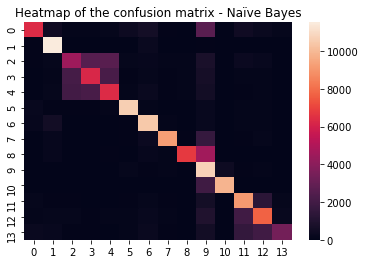

In [72]:
sns.heatmap(confusion_matrix(y_test, prediction))
plt.title("Heatmap of the confusion matrix - Naïve Bayes")
plt.show()

### Use cleanNameExtra function for preprocessing (Remove "film" tag)
From the analysis I have found that there are "film" tags in both class "Film" and "WrittenWork" so I thought it might confuse the model. Here I remove the "file" tag to see if improves the accuracy.

As a result, the accuracy was worsen. I can imagine that there are many names that belong to either "Film" or "WrittenWork" but it's difficult to be classified without the tag. So that overall accuracy worse off.

In [130]:
nb_clf.fit(X_train, y_train)
pickle.dump(nb_clf, open("resources/models/nb_model.pkl", "wb"))
prediction_train = nb_clf.predict(X_train)
prediction = nb_clf.predict(X_test)

In [131]:
print("Accuracy for training set is " + str(round(accuracy_score(y_train, prediction_train),4)))
print("Accuracy for test set is " + str(round(accuracy_score(y_test, prediction),4)))

Accuracy for training set is 0.8728
Accuracy for test set is 0.6737


In [133]:
confusion_matrix(y_test, prediction)

array([[ 6363,   459,   128,   112,   145,   396,   590,    82,    36,
         2683,     8,   484,   299,   169],
       [   68, 11532,     7,     7,    17,    10,   276,    10,     7,
           80,     2,    16,    25,    11],
       [   77,   140,  4526,  2591,  2639,   156,   223,   122,   100,
          787,    23,   336,   256,    15],
       [   43,    92,  2075,  6241,  2179,    89,   162,    67,   100,
          636,    15,    98,   127,     6],
       [   37,   161,  2024,  2187,  6385,   104,   311,    62,   121,
          548,     9,    89,   130,     3],
       [  251,    84,    76,    86,   102, 10644,   115,    39,    18,
          252,     9,   125,   127,    17],
       [  187,   549,    29,    21,    35,    64, 10459,    94,    27,
          246,     0,   128,   144,    27],
       [   38,   191,    27,    36,    37,    54,   328,  9233,    69,
         1629,     8,    63,   152,     3],
       [   31,   184,    28,    42,    53,    29,   207,    99,  6789,
         

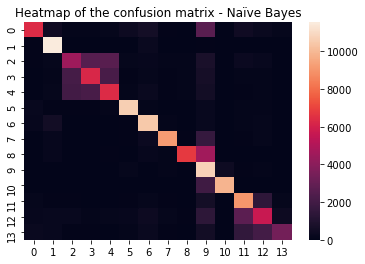

In [132]:
sns.heatmap(confusion_matrix(y_test, prediction))
plt.title("Heatmap of the confusion matrix - Naïve Bayes")
plt.show()

## Random Undersampling + bagging model
As there are less samples in class 14 (= WrittenWork) than other classes, I will try with a raondom undersampling method. Also this data set contains unique "Name" in each row, using bagging would make sense.
__Pros__
- The model can be trained in balanced data
- Because of bagging, the model can be trained on subsets of training data

__Cons__
- Because of random undersampling, the important characteristics of each classes might not be able to extracted comparison to no resampling method
- Computationally more expensive than bare Naïve bayes model

As a result, it improved quite a bit for the minor class (=14), however worse off in most other classes, especially the model is misclassifying "Company" names as "Vilage" and "Animal" names, which is quite interesting for human as Company names do sound different from both Village and Animal names. 

It would still depend on how important to classify class = 14 correctly, but I feel Naïve Bayes model is still doing better in general.

In [79]:
bbc_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', BalancedBaggingClassifier(base_estimator=MultinomialNB(alpha=1),
                                                       random_state=42)),])

In [137]:
bbc_clf.fit(X_train, y_train)
prediction_train = bbc_clf.predict(X_train)
prediction_bbc = bbc_clf.predict(X_test)

In [81]:
print("Accuracy for training set is " + str(round(accuracy_score(y_train, prediction_train),4)))
print("Accuracy for test set is " + str(round(accuracy_score(y_test, prediction),4)))

Accuracy for training set is 0.8717
Accuracy for test set is 0.6819


In [82]:
confusion_matrix(y_test, prediction)

array([[ 8855,   461,   126,   111,   154,   383,   602,    79,    39,
           17,    11,   438,   232,   446],
       [  135, 11554,     8,     8,    16,    13,   249,    10,     4,
            0,     2,    12,    20,    37],
       [  835,   158,  4344,  2642,  2710,   157,   240,   117,   100,
           23,    22,   321,   211,   111],
       [  645,   111,  1991,  6191,  2260,    97,   169,    70,   101,
           23,    13,    92,   117,    50],
       [  564,   177,  1887,  2191,  6479,   109,   304,    53,   118,
           18,     8,    88,   119,    56],
       [  463,    91,    87,    78,   109, 10584,   115,    38,    20,
           25,     9,   126,   106,    94],
       [  409,   547,    29,    19,    30,    66, 10443,    95,    26,
            6,     1,    97,   103,   139],
       [ 1657,   184,    29,    32,    31,    43,   326,  9231,    63,
           10,     8,    63,   124,    67],
       [ 4658,   186,    31,    44,    57,    30,   220,   101,  6758,
         

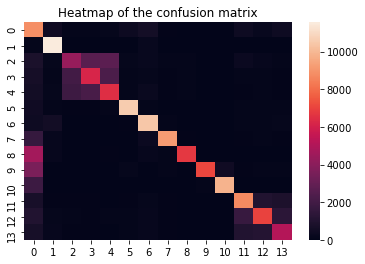

In [83]:
sns.heatmap(confusion_matrix(y_test, prediction))
plt.title("Heatmap of the confusion matrix")
plt.show()

## Combining Naïve Bayes and random undersampling + bagging
From above, we can see that using random undersampling + bagging improves the classifying the minority class. So I thought if I combine those predictions to Naïve Bayes prediction, it might improve the accuracy.

It improved the overall accuracy slightly, but considering increasing the computational cost, probably it's better to use Naïve Bayes model by itself.

In [138]:
combined_predictions = np.where(prediction_bbc==14,prediction_bbc,prediction)

In [139]:
print("Accuracy for test set is " + str(round(accuracy_score(y_test, combined_predictions),4)))

Accuracy for test set is 0.689


In [140]:
confusion_matrix(y_test, combined_predictions)

array([[ 6262,   441,   124,   110,   140,   387,   574,    82,    36,
         2679,     8,   428,   237,   446],
       [   64, 11518,     7,     7,    17,    10,   273,    10,     7,
           80,     2,    13,    23,    37],
       [   73,   140,  4511,  2584,  2632,   156,   219,   120,   100,
          787,    23,   326,   209,   111],
       [   41,    93,  2070,  6234,  2175,    88,   162,    65,   100,
          636,    15,    87,   114,    50],
       [   35,   159,  2017,  2183,  6377,   103,   308,    62,   121,
          547,     9,    85,   109,    56],
       [  240,    81,    75,    85,   101, 10618,   115,    39,    18,
          252,     9,   120,    98,    94],
       [  180,   541,    28,    19,    34,    63, 10433,    96,    27,
          246,     0,    98,   106,   139],
       [   38,   191,    27,    35,    36,    48,   321,  9221,    65,
         1627,     8,    58,   126,    67],
       [   30,   184,    28,    42,    52,    29,   207,    98,  6787,
         

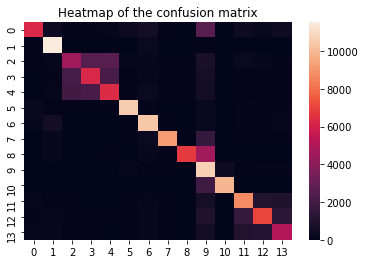

In [141]:
sns.heatmap(confusion_matrix(y_test, combined_predictions))
plt.title("Heatmap of the confusion matrix")
plt.show()

## FastText model
FastText is a library for text classification. I will see if this helps to improve the score of Naïve Bayes model.

__Pros__
- Relatively fast and reliable model performance including for "out of vocabulary (OOV)" cases
- Easy to use the high level library including some hyperparameters (learning rate and n-gram)

__Cons__
- Computationally more expensive than Naïve Bayes model and the model size tends to be big
- Documentation is poorly done (in my opinion) and couldn't figure out how to do the proper evaluation of the model (if I had more time I could explore a bit more)

Its accuracy is 0.7070 on the test set, which means successfully improved the score of Naïve Bayes. Yet since I couldn't figure out how to do the evaluation propoerly with this library, I will not use this model. But it is good to know that n-gram feture might be one of the reason why the model performance improved a bit so that I can try it with Naïve Bayes model. 

I did a little experiment with this model. I ran this model against some names and saw what will be the predicted class. When I tried with "streetbees ltd", it returned "Company" with likelihood of 0.9999. I think it is coming from "ltd". Also I tried with my name "kyosuke morita" (of course there's no my name in the dataset). The model predicted my name as "OfficeHolder", but when I add some "tag"s such as "boxer" and "bloger", the prediction changed to "Athlete" and "Artist", respectively. This means that the model learned a lot from the tags to classify the "human classes" and if we can have more of those, the accuracy will improve a lot.

In [102]:
# Preparation
ft_train_y, ft_test_y = y_train.apply(lambda x: '__label__' + str(x)), y_test.apply(lambda x: '__label__' + str(x))
ft_train, ft_test = pd.concat([X_train, ft_train_y],1), pd.concat([X_test, ft_test_y],1)

ft_train.to_csv("resources/data/train.txt",
                index = False,
                sep = ' ',
                header = None,
                quoting = csv.QUOTE_NONE,
                quotechar = "",
                escapechar = " ")

ft_test.to_csv("resources/data/test.txt",
                index = False,
                sep = ' ',
                header = None,
                quoting = csv.QUOTE_NONE,
                quotechar = "",
                escapechar = " ")

In [103]:
# Load pretrained vector
def loadVectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [105]:
ft_model = fasttext.train_supervised(input="resources/data/train.txt", 
                                     wordNgrams=2,
                                     lr=.07
                                    )

In [108]:
ft_model.save_model("resources/models/fasttext_model.bin")

In [110]:
score = ft_model.test("resources/data/train.txt")
print("Accuracy on the test set is " +
      str(2*score[1]*score[2]/(score[1]+score[2])))

Accuracy on the test set is 0.9949733177144344


In [107]:
score = ft_model.test("resources/data/test.txt")
print("Accuracy on the test set is " +
      str(2*score[1]*score[2]/(score[1]+score[2])))

Accuracy on the test set is 0.7070281892891634


In [109]:
ft_model.predict('streetbees ltd')

(('__label__1',), array([0.99999237]))

In [118]:
ft_model.predict('kyosuke morita')

(('__label__5',), array([0.73356813]))

In [119]:
ft_model.predict('kyosuke morita boxer')

(('__label__4',), array([0.9977569]))

In [123]:
ft_model.predict('kyosuke morita blogger')

(('__label__3',), array([0.404791]))

## Flair model
Similar to FastText, Flair is a NLP library. But this is known to be better than FastText in terms of model performance.
__Pros__
- Better model performance
- Can make use of "Flair embeddings" so that quite rubust for OOV cases as well
- Good documentation (compared to FastText)

__Cons__
- Computationally very expensive
- it couldn't run in my computer (I should have tried this on cloud or I could try with random undersampled data)

In [78]:
# Preparation
ft_train_y, ft_test_y = y_train.apply(lambda x: '__label__' + str(x)), y_test.apply(lambda x: '__label__' + str(x))
ft_train, ft_test = pd.concat([ft_train_y,X_train],1), pd.concat([ft_test_y,X_test],1)

ft_train.columns = ['label','text']
ft_test.columns = ['label','text']

ft_train.iloc[0:int(len(ft_train)*0.8)].to_csv("resources/data/train_flair.csv", 
                                           sep='\t', 
                                           index = False, 
                                           header = False)

ft_train.iloc[int(len(ft_train)*0.8):].to_csv("resources/data/dev_flair.csv", 
                                           sep='\t', 
                                           index = False, 
                                           header = False)
                

ft_test.to_csv("resources/data/test_flair.csv",
               sep='\t',
               index = False,
               header = False)

In [9]:
column_name_map = {0:"label", 1:"text"}
corpus = CSVClassificationCorpus(Path('./resources/data/'),
                                 column_name_map=column_name_map,
                                 train_file='train_flair.csv',
                                 dev_file='dev_flair.csv',
                                 test_file='test_flair.csv',
                                 skip_header=True,
                                 delimiter=' ')

2021-02-10 20:36:42,529 Reading data from resources/data
2021-02-10 20:36:42,533 Train: resources/data/train_flair.csv
2021-02-10 20:36:42,534 Dev: resources/data/dev_flair.csv
2021-02-10 20:36:42,535 Test: resources/data/test_flair.csv


In [10]:
label_dict_csv = corpus.make_label_dictionary()

2021-02-10 20:36:44,048 Computing label dictionary. Progress:


100%|██████████| 417264/417264 [01:23<00:00, 4971.16it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




In [11]:
word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), FlairEmbeddings('news-backward-fast')]
document_embeddings = DocumentLSTMEmbeddings(word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=256)

<ipython-input-11-da5b3f9fc6fb>:2: DeprecationWarning: Call to deprecated method __init__. (The functionality of this class is moved to 'DocumentRNNEmbeddings') -- Deprecated since version 0.4.
  document_embeddings = DocumentLSTMEmbeddings(word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=256)


In [12]:
classifier = TextClassifier(document_embeddings, 
                            label_dictionary=label_dict_csv, 
                            multi_label=False)

trainer = ModelTrainer(classifier, corpus)

In [ ]:
trainer.train('./resources/flair_logs/', max_epochs=10)

2021-02-10 20:38:36,511 ----------------------------------------------------------------------------------------------------
2021-02-10 20:38:36,513 Model: "TextClassifier(
  (document_embeddings): DocumentLSTMEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=2148, out_features=256, bias=True)
    (rnn): GRU(256, 512)
 